In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.getenv("GROQ_API_KEY")

In [2]:
model="deepseek-r1-distill-llama-70b"

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model=model)

In [ ]:
from langgraph.graph import StateGraph,END,MessagesState,START
from langgraph.graph.message import add_messages
from langchain.tools import tool

In [5]:
def call_model(state:MessagesState):
    
    message = state['messages']
    response = llm.invoke(message)
    
    return {"messages":[response]}

In [6]:
state = {'messages':"hi"}
res=call_model(state)

In [7]:
print(res['messages'][0].content)

<think>

</think>

Hello! How can I assist you today? 😊


In [8]:
workflow = StateGraph(MessagesState)
workflow.add_node("mybot",call_model)
workflow.add_edge(START,"mybot")
workflow.add_edge("mybot",END)
app = workflow.compile()

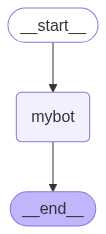

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
res = app.invoke({"messages":"hi how are you"})

In [11]:
res

{'messages': [HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='6ed8032a-23a5-4ce2-902b-5c18192b29b6'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 7, 'total_tokens': 51, 'completion_time': 0.19273576, 'prompt_time': 0.000180678, 'queue_time': 0.056435792000000005, 'total_time': 0.192916438}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--755cd372-7871-4a86-b6dc-92cbc9a0beff-0', usage_metadata={'input_tokens': 7, 'output_tokens': 44, 'total_tokens': 51})]}

In [12]:
print(res["messages"][1].content)

<think>

</think>

Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊


In [ ]:
@tool
def search(query:str):
    """This is custom tool searching weather"""
    
    if "delhi" in query.lower():
        return "the temperature is 19 degrees"
    else:
        return "it is sunny"

In [14]:
search.invoke("delhi")

'the temperature is 19 degrees'

In [15]:
tools = [search]
tools

[StructuredTool(name='search', description='This is custom tool searching weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C58C0F1280>)]

In [16]:
llm_with_tools = llm.bind_tools(tools)
response = llm_with_tools.invoke("what is a weather in delhi")

In [17]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'd108dqgg7',
  'type': 'tool_call'}]

In [18]:
def call_model(state:MessagesState):
    question = state['messages']
    response = llm_with_tools.invoke(question)
    return {'messages':[response]}

In [25]:
def router_function(state:MessagesState):
    message = state['messages']
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "llm"

In [27]:
def llm_call(state:MessagesState):
    question = state['messages']
    response = llm.invoke(question)
    return response

In [28]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

workflow2 = StateGraph(MessagesState)
workflow2.add_node("llm_with_tool",call_model)
workflow2.add_node("mytools",tool_node)
workflow2.add_node("llm",llm_call)
workflow2.add_edge("llm",END)
workflow2.add_edge(START, "llm_with_tool")
workflow2.add_conditional_edges(
	"llm_with_tool",
    router_function,
    {
		"tools":"mytools",
        "llm":"llm"
	}
)

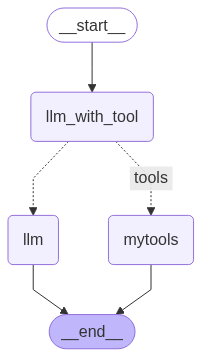

In [29]:
workflow2.compile()

In [30]:
app2 = workflow2.compile()

In [31]:
input={"messages":['what is temperature of delhi?']}
app2.invoke(input)

{'messages': [HumanMessage(content='what is temperature of delhi?', additional_kwargs={}, response_metadata={}, id='de4fa77e-c700-4b6c-b1f4-56de4cdbfdf1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vsg2b6121', 'function': {'arguments': '{"query":"temperature of Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 223, 'prompt_tokens': 129, 'total_tokens': 352, 'completion_time': 0.96618025, 'prompt_time': 0.008339096, 'queue_time': 0.05617251399999999, 'total_time': 0.974519346}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0bb951b5-ce49-4605-9f27-cebcc57995da-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature of Delhi'}, 'id': 'vsg2b6121', 'type': 'tool_call'}], usage_metadata={'input_tokens': 129, 'output_tokens': 223, 'total_tokens': 352}),
  ToolMessage(content='the temperature is 19 degrees

In [33]:
input={"messages":['hi']}
app2.invoke(input)

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b7a3a431-fc9f-43df-acd2-4be1aff909e7'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 123, 'total_tokens': 202, 'completion_time': 0.377043868, 'prompt_time': 0.00803264, 'queue_time': 0.061041279999999996, 'total_time': 0.385076508}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--42c482a8-d2dc-4020-ad0f-9b16e04f1919-0', usage_metadata={'input_tokens': 123, 'output_tokens': 79, 'total_tokens': 202})]}